In [ ]:
! pip install ultralytics
! pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.1 MB/s eta 0:00:00


In [ ]:
pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e0ab73ab897a8884454d7bebf0f64f2b2ee5c652e2ad271d20c4cf039945be41
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

In [ ]:
train_imgs_dir="/content/drive/MyDrive/data/training_images"
train_labels="/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv"

test_imgs_dir="/content/drive/MyDrive/data/testing_images"

In [ ]:
imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]

In [ ]:
#yolo dataset format

# root directory
!mkdir "/content/drive/MyDrive/data"

# images directory
!mkdir "/content/drive/MyDrive/data/images"

# train and test subdirectories with image directory
!mkdir "/content/drive/MyDrive/data/images/train"
!mkdir "/content/drive/MyDrive/data/images/val"

# labels directory
!mkdir "/content/drive/MyDrive/data/labels"

# train and test subdirectories with labels directory
!mkdir "/content/drive/MyDrive/data/labels/train"
!mkdir "/content/drive/MyDrive/data/labels/val"

mkdir: cannot create directory ‘/content/drive/MyDrive/data’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/data/images’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/data/images/train’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/data/images/val’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/data/labels’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/data/labels/train’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/data/labels/val’: File exists


In [ ]:
root_dir="/content/drive/MyDrive/data"
labels_dir="/content/drive/MyDrive/data/labels"
images_dir="/content/drive/MyDrive/data/images"

In [ ]:
df=pd.read_csv(train_labels)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [ ]:
for idx,img_name in enumerate(imgs_list):
    subset="train"
    if idx in val_idx:
        subset="val"

    if np.isin(img_name,df_yolo["img_name"]):
        columns=["class","x_centre","y_centre","width","height"]
        img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values

        label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
        with open(label_file_path,"w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")

    old_image_path=os.path.join(train_imgs_dir,img_name)
    new_image_path=os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)

In [ ]:
yolo_format=dict(path="/content/drive/MyDrive/data",
                 train="/content/drive/MyDrive/data/images/train",
                 val="/content/drive/MyDrive/data/images/val",
                 nc=1,
                 names={0:"car"})

with open('/content/drive/MyDrive/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login(key="9e49f3f7e258c70df2271ab602dcf5c90870d6ab")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
1

In [ ]:
model=YOLO('yolov8m.pt')
model.train(data="/content/drive/MyDrive/yolo.yaml",epochs=5,patience=5,batch=8,
                    lr0=0.0005,imgsz=640)

100%|██████████| 49.7M/49.7M [00:00<00:00, 418MB/s]
Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/yolo.yaml, epochs=5, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torch

Freezing layer 'model.22.dfl.conv.weight'
train: Scanning /content/drive/MyDrive/data/labels/train.cache... 355 images, 650 backgrounds, 0 corrupt: 100%|██████████| 1005/1005 [00:00<?, ?it/s]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/drive/MyDrive/data/labels/val... 224 images, 439 backgrounds, 0 corrupt: 100%|██████████| 663/663 [00:38<00:00, 17.07it/s]
val: New cache created: /content/drive/MyDrive/data/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/5         0G      1.475      1.3

In [ ]:
path_best_weights="/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)

metrics = model.val()

Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (AMD EPYC 7B12)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/data/labels/val.cache... 224 images, 439 backgrounds, 0 corrupt: 100%|██████████| 663/663 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [07:35<00:00, 10.86s/it]
                   all        663        340      0.968      0.966      0.989      0.628
Speed: 0.6ms preprocess, 672.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val


In [ ]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.6282695401929789
Mean Average Precision @ .50   : 0.9894029065914673
Mean Average Precision @ .70   : 0.7337295079019953


In [ ]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.50,iou=0.75)


image 1/175 /content/drive/MyDrive/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 827.9ms
image 2/175 /content/drive/MyDrive/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 800.9ms
image 3/175 /content/drive/MyDrive/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 833.4ms
image 4/175 /content/drive/MyDrive/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 650.2ms
image 5/175 /content/drive/MyDrive/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 656.2ms
image 6/175 /content/drive/MyDrive/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 631.7ms
image 7/175 /content/drive/MyDrive/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 644.9ms
image 8/175 /content/drive/MyDrive/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 636.1ms
image 9/175 /content/drive/MyDrive/data/testing_images/vid_5_25260.jpg: 384x640 (no detections), 623.2ms
image 10/175 /content/drive/MyDrive/data/testing_image

In [ ]:
# directory for saving predictions on test dataset
!mkdir "/content/drive/MyDrive/data/predictions"

In [ ]:
prediction_dir="/content/drive/MyDrive/data/predictions"

In [ ]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()

        test_img_list.append(name)

        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [ ]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    axis.imshow(img)
    axis.axis("off")

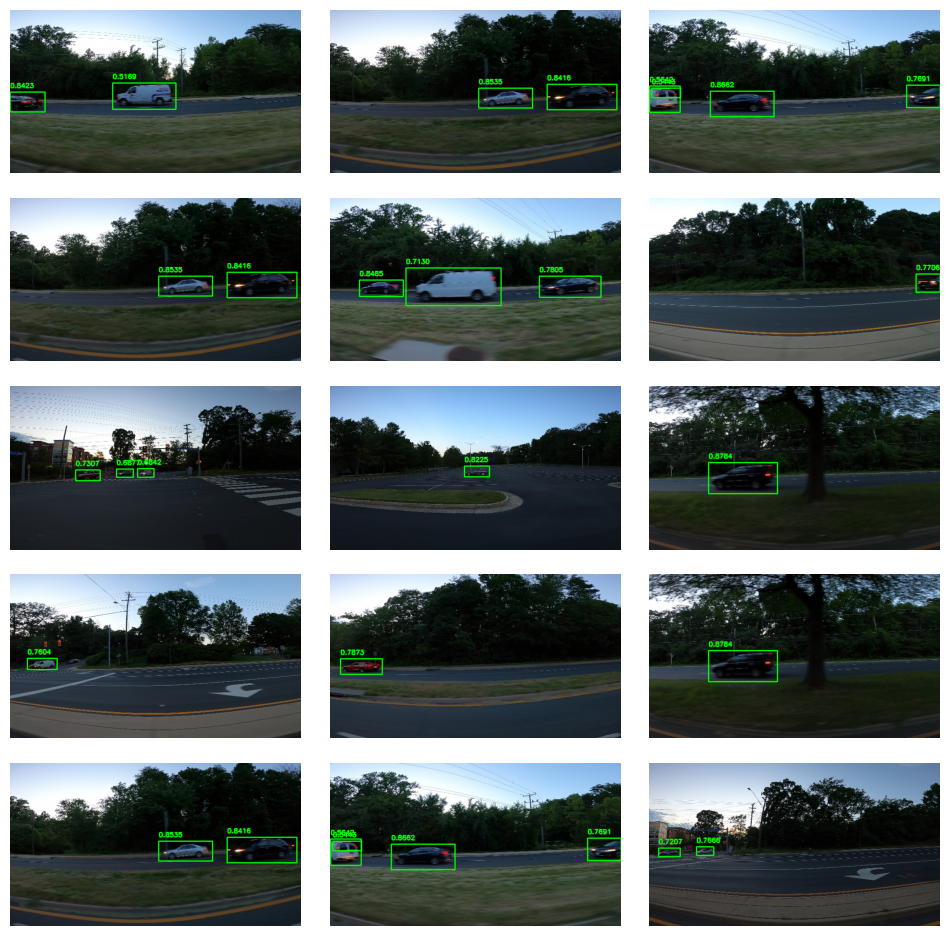

In [ ]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])

plt.savefig("1.png")